In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from os import path
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.linear_model import LinearRegression

labels = ["paiceHusk", "krovetz", "sStripping", "porter2", "lovins", "wikt", "none"]
maxLengths = [20,55,148,403,1097,2981,2000000] #may need to update largest length

home_dir = "/home/katelyn/Documents/COSC490/Stemming"
data_dir_clueweb = path.join(home_dir, "Data/clueweb")
data_dir_wikt = path.join(home_dir, "Data/wikt")

MARKERS = ["o","^","s","*","d", "P", "X"]
markers = itertools.cycle(MARKERS)

### Preparing Data

In [5]:
df_list = list()

for l in maxLengths:
   df = pd.read_csv(path.join(data_dir_clueweb,f"documentLength/ndcg_{l}"), sep=" ")
   df_list.append(df)

data = pd.concat(df_list, ignore_index=True)

data_avg = data[data["qid"] == "amean"]
data = data.drop(data[data["qid"] == "amean"].index)

### Overall nDCG

In [8]:
target_data = data_avg

best_nDCG = list()
for length in maxLengths:
    selected_data = data_avg[data_avg["maxLength"] == length]
    best_nDCG.append(selected_data["ndcg"].max())

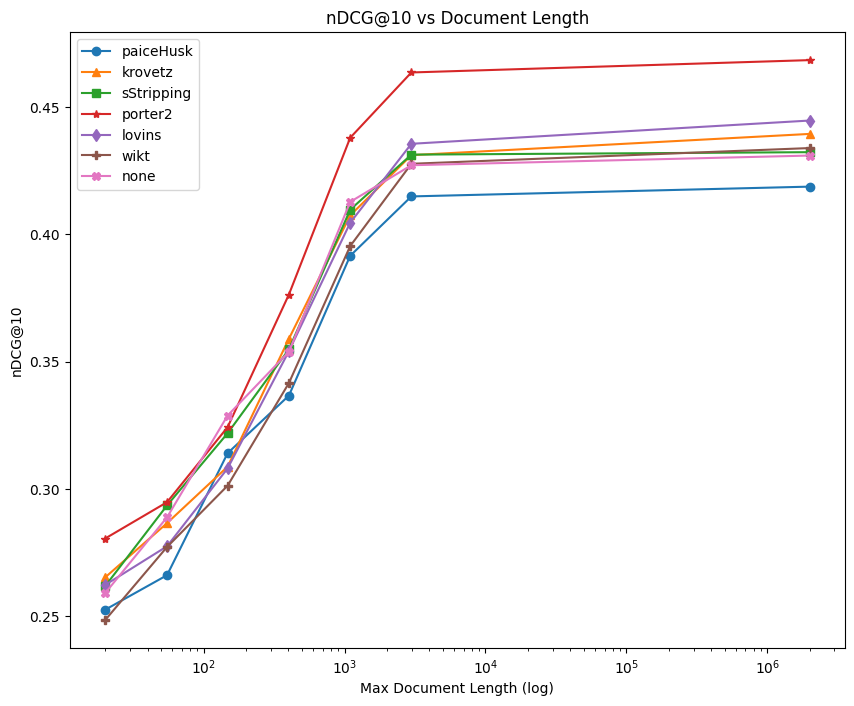

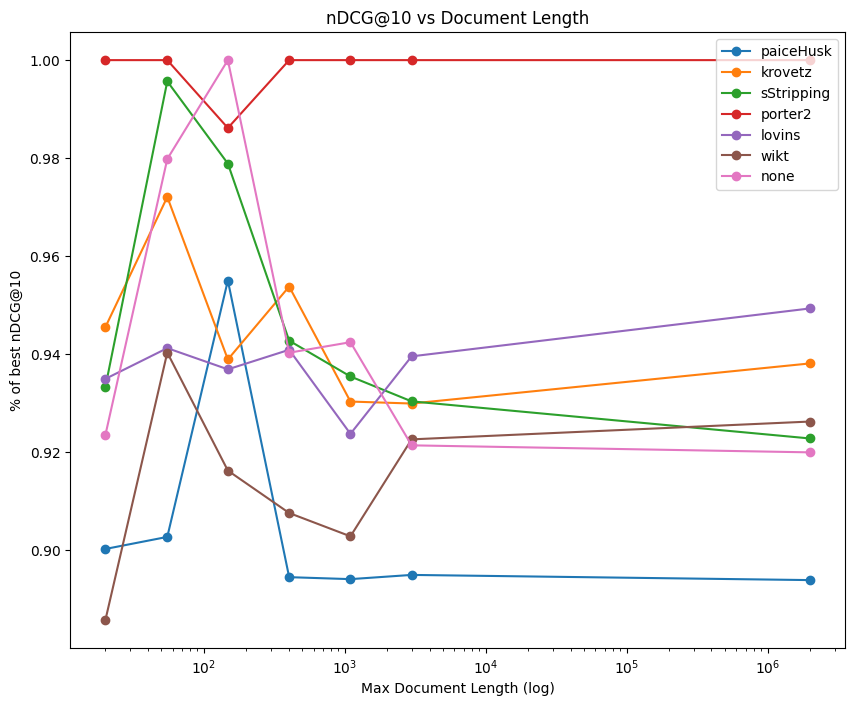

In [7]:
plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    plt.plot(stemmer_data["maxLength"], stemmer_data["ndcg"], marker=next(markers), label=stemmer)
    plt.xscale("log")

plt.title("nDCG@10 vs Document Length")
plt.xlabel("Max Document Length (log)")
plt.ylabel("nDCG@10")
plt.legend()
plt.show()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["ndcg"])/best_nDCG
    plt.plot(stemmer_data["maxLength"], stemmer_values, "o-", label=stemmer)
    plt.xscale("log")
plt.title("nDCG@10 vs Document Length")
plt.xlabel("Max Document Length (log)")
plt.ylabel("% of best nDCG@10")
plt.legend()
plt.show()

### Statistical Significance

In [9]:
#t-test between the porter2 stemmer (one of the best performing) and no stemming
for length in maxLengths:
    s = list()
    n = list()
    target_data = data[data["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"Length: {length} {stats.ttest_rel(s,n)}")

Length: 20 TtestResult(statistic=1.7665999388424738, pvalue=0.08037735243864251, df=99)
Length: 55 TtestResult(statistic=0.4382824882384144, pvalue=0.662136393576339, df=99)
Length: 148 TtestResult(statistic=-0.3187949973190452, pvalue=0.7505535913758914, df=99)
Length: 403 TtestResult(statistic=1.3126198948858705, pvalue=0.19234593379515186, df=99)
Length: 1097 TtestResult(statistic=1.54450740281744, pvalue=0.1256561433978207, df=99)
Length: 2981 TtestResult(statistic=2.0877942331378647, pvalue=0.03938367199659063, df=99)
Length: 2000000 TtestResult(statistic=2.1703210420603334, pvalue=0.032374053378288414, df=99)


In [10]:
#t-test between paiceHusk and none
for length in maxLengths:
    s = list()
    n = list()
    target_data = data[data["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"Length: {length} {stats.ttest_rel(s,n)}")

Length: 20 TtestResult(statistic=-0.5604725617799289, pvalue=0.5764233440905526, df=99)
Length: 55 TtestResult(statistic=-1.578218604222821, pvalue=0.11770546792085093, df=99)
Length: 148 TtestResult(statistic=-1.14613287614471, pvalue=0.25450296213119256, df=99)
Length: 403 TtestResult(statistic=-1.1477447532689835, pvalue=0.2538399221228036, df=99)
Length: 1097 TtestResult(statistic=-1.2212446851261605, pvalue=0.22489376239756298, df=99)
Length: 2981 TtestResult(statistic=-0.5993940103502067, pvalue=0.5502794601167289, df=99)
Length: 2000000 TtestResult(statistic=-0.6122980873747164, pvalue=0.5417443633108274, df=99)


In [11]:
#t-test between porter2 and paiceHusk
for length in maxLengths:
    s = list()
    n = list()
    target_data = data[data["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"ndcg"].tolist()
    print(f"Length: {length} {stats.ttest_rel(s,n)}")

Length: 20 TtestResult(statistic=2.2189842086894678, pvalue=0.028771268731622612, df=99)
Length: 55 TtestResult(statistic=2.0679933691914187, pvalue=0.04124827003944356, df=99)
Length: 148 TtestResult(statistic=0.9251817838135777, pvalue=0.3571210893346699, df=99)
Length: 403 TtestResult(statistic=2.697480785892367, pvalue=0.008213796374198598, df=99)
Length: 1097 TtestResult(statistic=2.7216312677184438, pvalue=0.007676257120599726, df=99)
Length: 2981 TtestResult(statistic=2.6542724286647683, pvalue=0.009261522781402232, df=99)
Length: 2000000 TtestResult(statistic=2.653878331834531, pvalue=0.009271612457695729, df=99)


In [12]:
#t-test between wikt and none
for length in maxLengths:
    s = list()
    n = list()
    target_data = data[data["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "wikt"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"Length: {length} {stats.ttest_rel(s,n)}")

Length: 20 TtestResult(statistic=-0.8634571081919793, pvalue=0.38997326807340105, df=99)
Length: 55 TtestResult(statistic=-0.9711665307594503, pvalue=0.3338321732439248, df=99)
Length: 148 TtestResult(statistic=-2.1206632071612783, pvalue=0.03644877373770261, df=99)
Length: 403 TtestResult(statistic=-0.7659296556513513, pvalue=0.4455404990953329, df=99)
Length: 1097 TtestResult(statistic=-1.1641195186860505, pvalue=0.24717335903099613, df=99)
Length: 2981 TtestResult(statistic=0.030991184367895667, pvalue=0.9753389630927085, df=99)
Length: 2000000 TtestResult(statistic=0.1718614466393791, pvalue=0.8638972766048061, df=99)
